# QUANDL API KEY 'MYsN5o36XrdV73TrbWWU'

# Disclaimer, I have chosen to use the sample QUANDL database from the exercise to perform the task as most of the QUANDL data sets are either deprecated or are premium/paid access only. I can not find a relevant data set for my project. This task will be done for educational purposes to learn Time Series Analysis.

In [1]:
# Install Quandl library

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight')

In [3]:
# Find & Import Data Set

In [4]:
# Configure API key
quandl.ApiConfig.api_key = '5328unmhFUBfdDyQ3vdx'

In [5]:
data = quandl.get('FRED/NROU') # Natural Rate of Unemployment Data from the Federal Reserve Economic Data

In [6]:
data.head()

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [7]:
data.shape

(332, 1)

In [8]:
data.columns

Index(['Value'], dtype='object')

# Subsetting & Wrangling

# We want only data after January 1980 and before June 2020

In [9]:
# reset index
data_2 = data.reset_index()

In [10]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [11]:
# Setting the date as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # create a datetime column from 'Date'
data_sub = data_sub.set_index('datetime') # set the datetime as the index of the dataframe
data_sub.drop(['Date'], axis=1, inplace=True) # drop the 'Date' column
data_sub.head()

,Value
datetime,
1980-01-01,6.217371
1980-04-01,6.210709
1980-07-01,6.203388
1980-10-01,6.195496
1981-01-01,6.187123


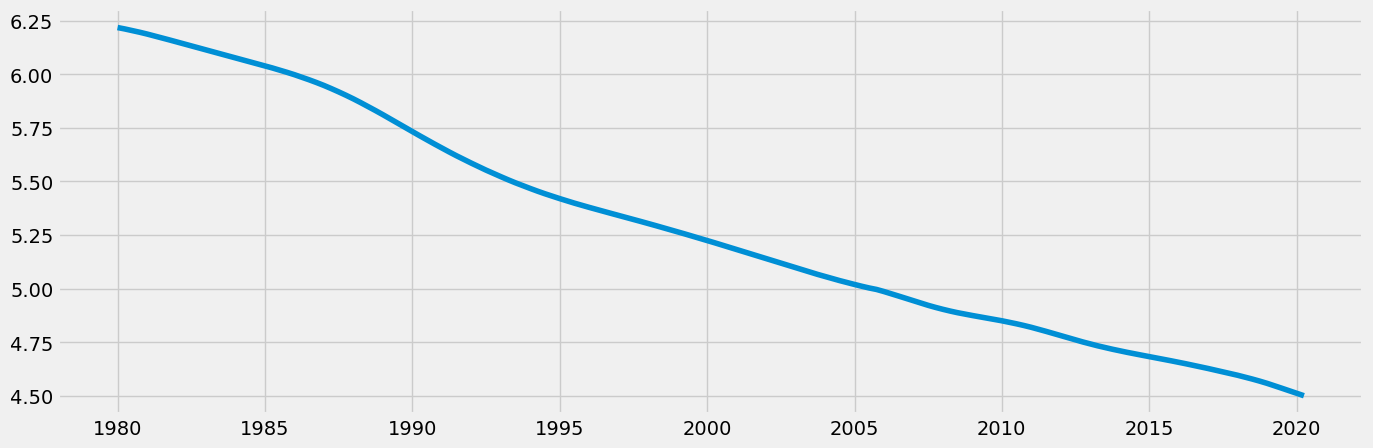

In [12]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data_sub)

# Decompose Data Components

In [13]:
# Decompose time series using the additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [14]:
# Define fixed size for all charts
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

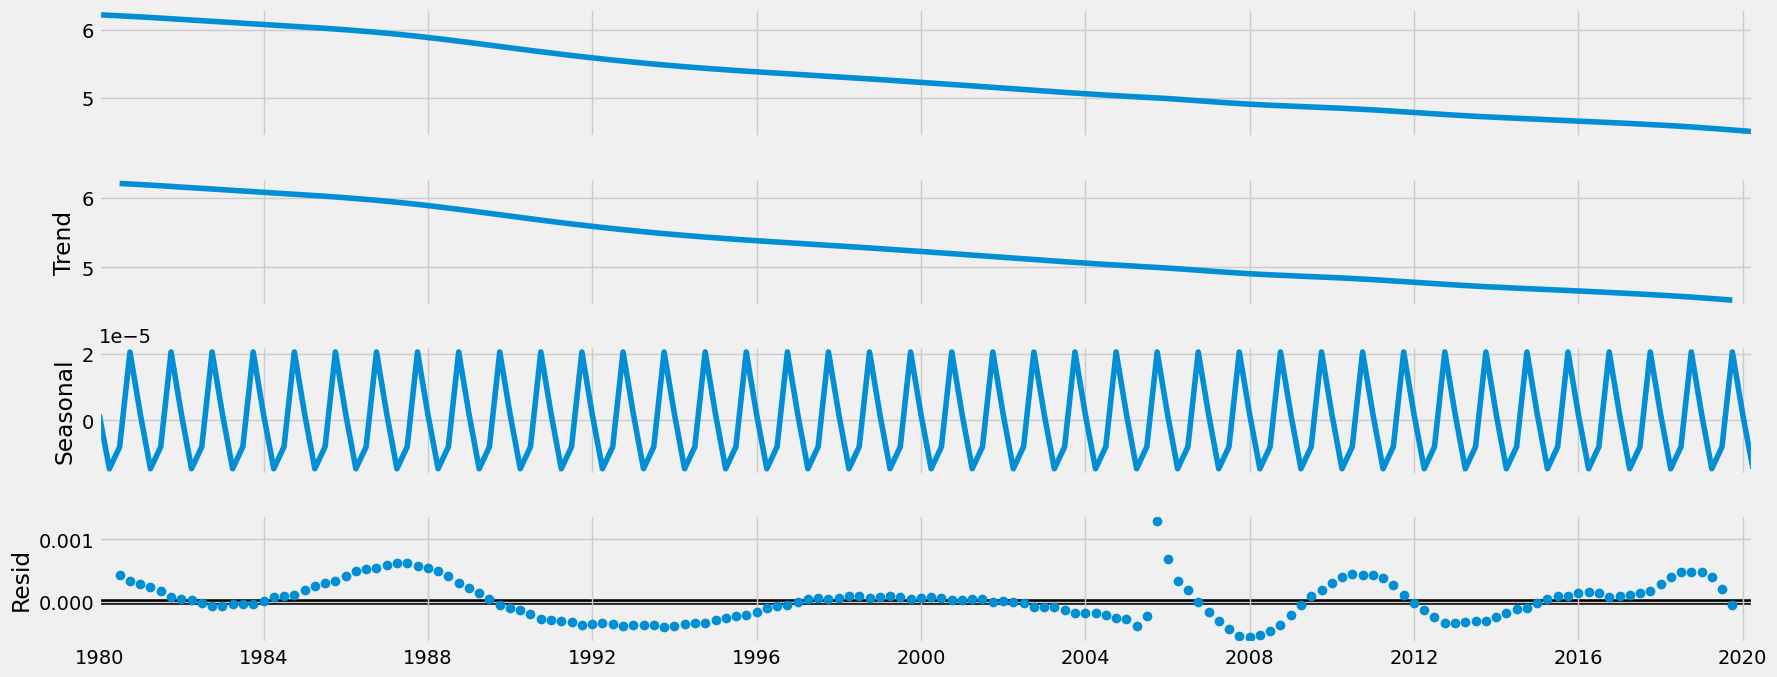

In [15]:
# Plot separate components

decomposition.plot()
plt.show()

There is a downward linear trend in the Natural Rate of Unemployment. From the decomposition, Seasonality shows regular intervals. The Residual stays close to the line and does not require smoothing.

# Dickey-Fuller test

In [21]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller 

# Define the function
def dickey_fuller(timeseries): 
    
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.745331
p-value                          0.407921
Number of Lags Used              4.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


Null Hypothesis: The time series has a unit root, and thus, it is non-stationary.
Alternative Hypothesis: The time series is stationary after differencing.

"Test Statistic" is greater than the Critical Value, therefore we must Stationarize the data.

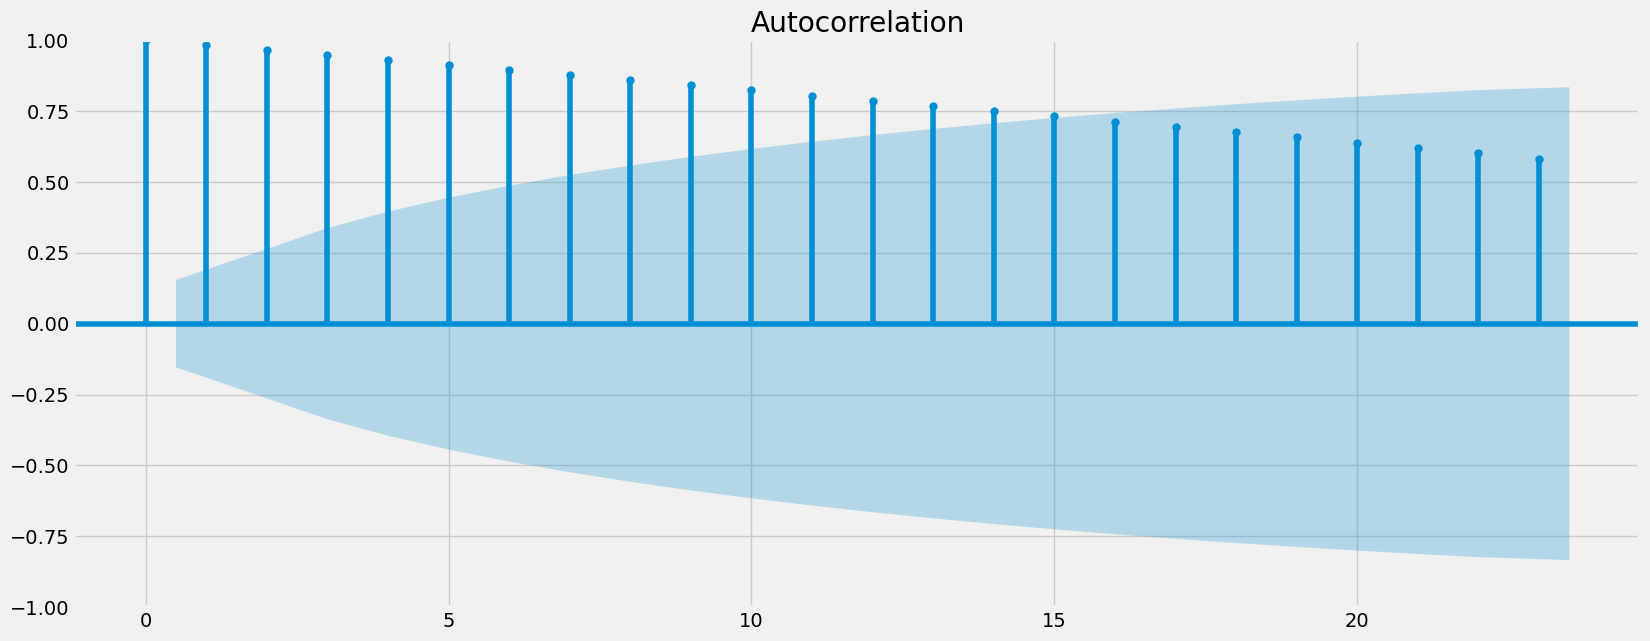

In [22]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(data_sub)
plt.show()

## Many blue lines above the blue area (confidence interval); therefore, we can confirm the data is not stationary.

# Round of Differencing (to stationarize the data)

In [23]:
data_diff = data_sub - data_sub.shift(1) 

In [25]:
# Remove missing values that come as a result of differencing
data_diff.dropna(inplace = True)

In [26]:
data_diff.head()

,Value
datetime,
1980-04-01,-0.006662
1980-07-01,-0.007321
1980-10-01,-0.007892
1981-01-01,-0.008373
1981-04-01,-0.008762


In [27]:
data_diff.columns

Index(['Value'], dtype='object')

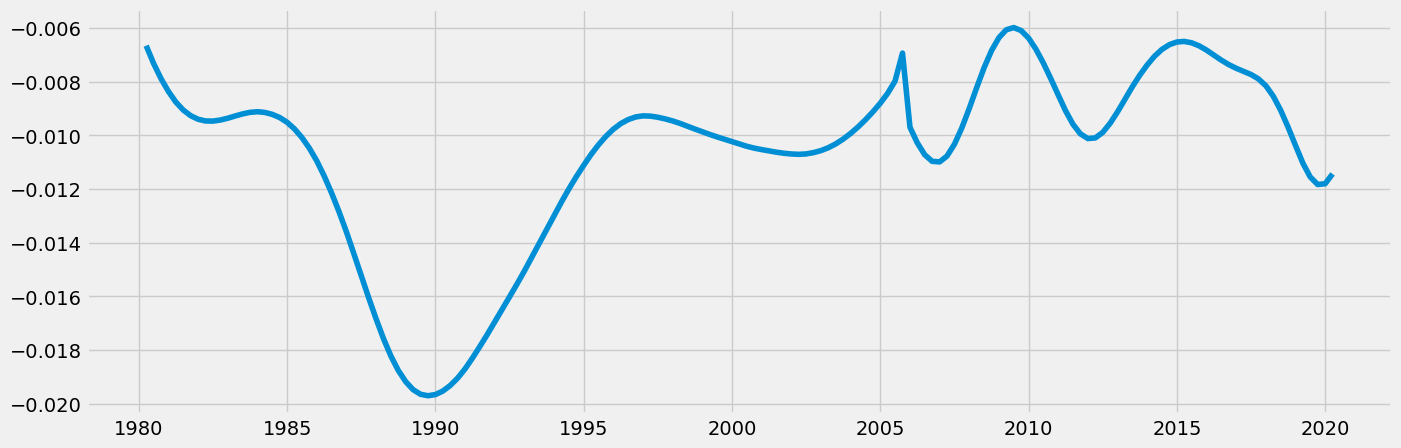

In [28]:
# See what effect differencing has made to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [29]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.451840
p-value                          0.127636
Number of Lags Used              2.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64


Test Statistic is now LESS than the 5% and 10% Critical Value!

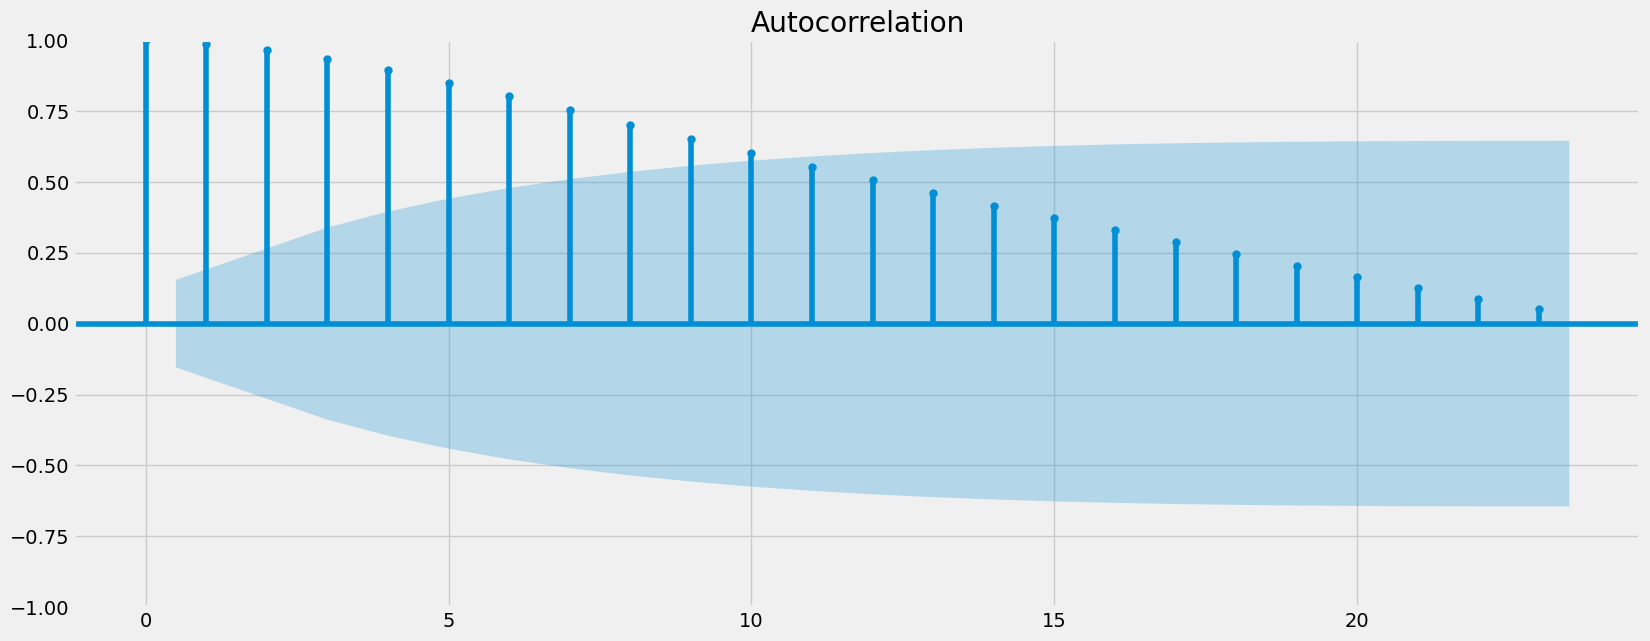

In [30]:
plot_acf(data_diff)
plt.show()

# Another round of differencing

In [31]:
# Second round of differencing
data_diff2 = data_diff.diff().dropna()

# Apply Dickey-Fuller test on the second differenced series
dickey_fuller(data_diff2['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -3.807206
p-value                          0.002834
Number of Lags Used              1.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64


Test Statistic is lower than all Critical Values suggesting the data is stationary.

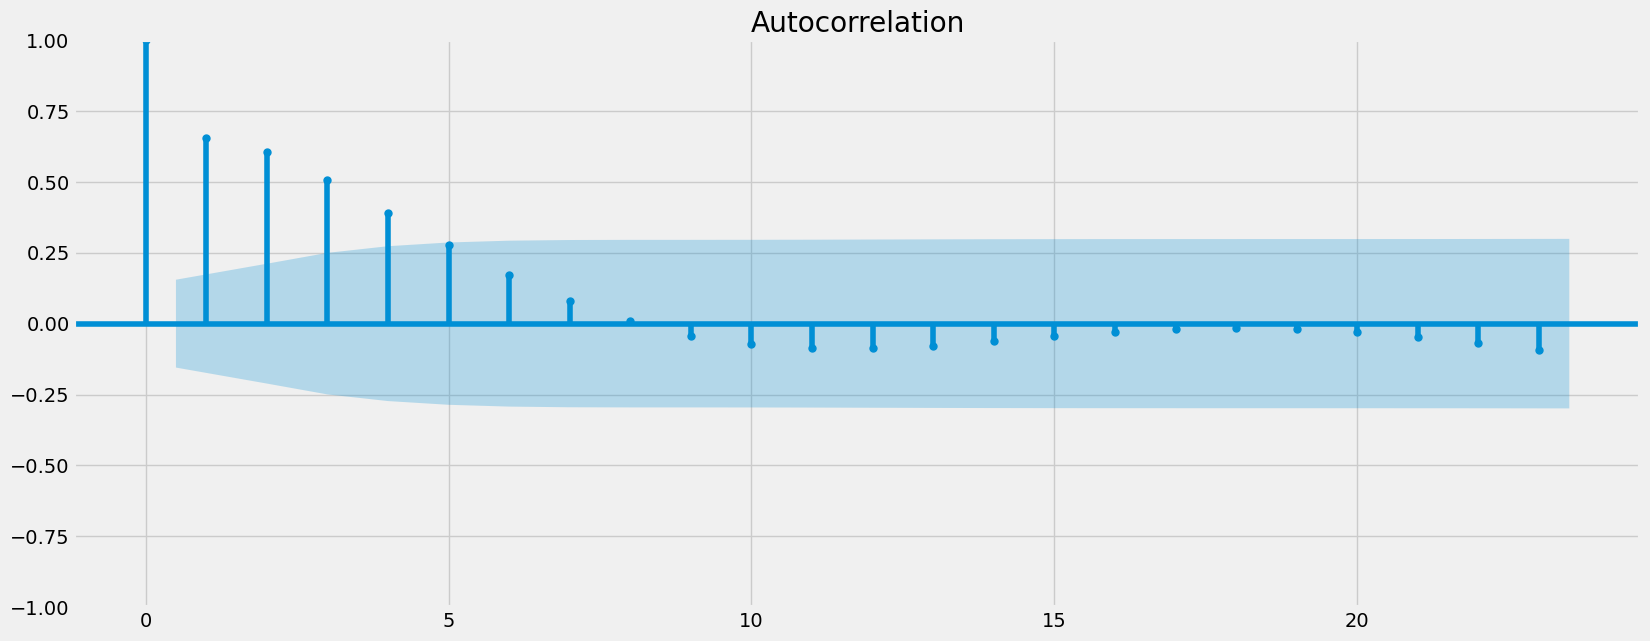

In [32]:
plot_acf(data_diff2)
plt.show()

There are only a few lags outside the confidence interval, therefore the data is close to stationarity.